# Intro to Deep Learning (Complete)

This is a complete implementation of our simple 2-layer neural network. Use this as a reference or to check your work.

## Overview

In this notebook we'll train a simple neural network to predict flower species using the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/Iris). This dataset contains the petal and sepal measurements of 150 flowers of three different types: Iris Setosa, Iris Versicolor, and Iris Virginica (there are 50 of each type). Each flower has four associated measurements: sepal length, sepal width, petal length, and petal width (in cm).

We'll use [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179) to enocde classes. Basically it works like this: If there are 3 possible classes, and a certain example belongs in the first class, its y-value will be represented as `[1,0,0]`. Second class is `[0,1,0]`, and so on.

Each example will have 4 inputs (the four measurements for each flower) and 3 outputs. Each output is the probability that the flower belongs to each class.

The network will have one hidden layer.

![network](https://cdn-images-1.medium.com/max/1200/1*QVIyc5HnGDWTNX3m-nIm9w.png)

## Load the data

The `X` variable is a 4 x 150 array, where each column represents one flower example.
The $i$th column looks like $\begin{bmatrix}
    x^i_{\textrm{sepal length}} \\
    x^i_{\textrm{sepal width}} \\
    x^i_{\textrm{petal length}} \\
    x^i_{\textrm{petal width}}
\end{bmatrix}$
where each entry is the measurement.

The `y` variable is a 3 x 150 array.
The $i$th column looks like $\begin{bmatrix}
    y^i_{\textrm{setosa}} \\
    y^i_{\textrm{versicolor}} \\
    y^i_{\textrm{virginica}} 
\end{bmatrix}$
where each entry is 1 or 0 depending on whether the example belongs to that class.

Load the data:

In [13]:
from urllib.request import urlopen
import numpy as np
# from numpy import loadtxt

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data'
raw_data = str(urlopen(url).read())[2:-5]
rows = str(raw_data).split("\\n")

X = np.array([np.array(r.split(",")[:-1]) for r in rows]).astype(float)
X = X.T

y = np.zeros((150,3))
y[:50,0] = 1
y[50:100,1] = 1
y[100:150,2] = 1
y = y.T

# make sure it loaded correctly
load_sample = (np.random.rand(5)*150).astype(int)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print()

print("5 columns of X:")
print(X[:,load_sample])

print("5 corresponding columns of y:")
print(y[:,load_sample])

Shape of X: (4, 150)
Shape of y: (3, 150)

5 columns of X:
[[6.2 6.2 4.4 7.9 7.9]
 [2.2 2.8 3.  3.8 3.8]
 [4.5 4.8 1.3 6.4 6.4]
 [1.5 1.8 0.2 2.  2. ]]
5 corresponding columns of y:
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1.]]


Note that each column in the 5 columns of $y$ has exactly one entry of 1, and the rest are 0. When we predict $\hat{y}$, we want the prediction for the true class to be close to 1, and the predictions for the other classes to be close to 0.

## Initialization

Two weight matrices (`W1` and `W2`) and two biases (`b1` and `b2`) need to be initialized. Their sizes depend on the number of entries in each example (`n_x`), the number of hidden nodes (`n_h`) and the number of classes (`n_y`).

Each layer of the network transforms the input vector into a different vector space of some number of dimensions.
The size of `W1` is `n_h` by `n_x`, to transform an `n_x`-dimensional input vector into an `n_h`-dimensional vector in the hidden layer. `b1` is size `n_h`, and is added to the hidden layer vector as bias.
The size of `W2` is `n_y` by `n_h`, to transform an `n_h`-dimensional hidden layer vector into an `n_y`-dimensional vector representing class probabilities. Bias vector `b2` is size `n_y`.

Below, fill in the function to set the size of the input, hidden layer, and output, initialize the weights with small random values, and initialize the biases to 0.

In [2]:
def initialize_parameters(n_x, n_h, n_y):
    '''
    Input
    -----
    n_x: size of example input vector
    n_h: number of nodes in the hidden layer
    n_y: number of classes
    
    Output
    ------
    parameters: dictionary of initialized weights
    '''
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    return parameters

## Forward Propogation

Forward propogation computes the probabilities of a certain example belonging to each class. Each prediction is between 0 and 1 (the range of the `sigmoid` function).

Here's the math for moving one example through the network:

* Input is $x$ ($x$ is a `n_x`-d column vector)
* First transformation, $W_1 \cdot x + b_1 = z_1$ ($z_1$ is a `n_h`-d vector)
* Apply activation function, $a_1 = \textrm{tanh}(z_1)$ (dimension stays the same)
* Second transformation, $W_2 \cdot a_1 + b_2 = z_2$ ($z_2$ is a `n_y`-d vector)
* Apply activation function, $a_2 = \textrm{sigmoid}(z_2)$ (dimension stays the same)
* The predicted class scores are $\hat{y} = a_2$


Doing this separately for every single example is slow, so we use vectorization to process multiple examples at once. If we process `n` examples, the input $x$ becomes $X$, a `n_x` by `n` matrix, and $\hat{y}$ becomes a `n_y` by `n` matrix.


Implement the forward pass of the network:

In [3]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def forward_propogation(X, parameters):
    '''
    Input
    -----
    X: array of input examples (shape: num_measurements x num_examples)
    parameters: dictionary of weights
    
    Output
    ------
    y_hat: probabilities of predicted classes (shape: num_classes x num_examples)
    cache: intermediate values (used in backpropogation)
    '''
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    y_hat = A2 = sigmoid(Z2) # y_hat are the predicted scores, 0 < score < 1, for each of the classes
    
    # save intermediate values for backpropogation
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "y_hat": y_hat}
    
    return y_hat, cache

## Cost

We need some way to know how well our neural network is performing. We define a loss function to compute how wrong each output of the network was. The cost is the average loss over all the training examples.

Here, we will use the logarithmic loss function. 

For each individual class prediction (e.g. for 100 examples with 4 classes that would be 400 individual predictions when we predict the probability of each example being in each class), if the true value for a particular class prediction is 0 (e.g. an Iris virginica would be labeled with a 0 for the Iris setosa class), the loss is $-log(1-\hat{y})$, and looks like this:

In [4]:
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: could not find rc file; returning defaults
  warnings.warn(message)


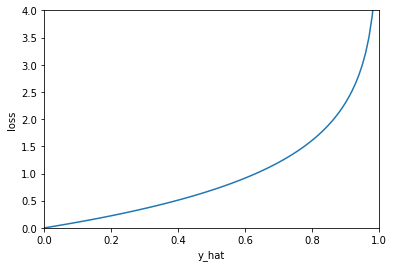

In [5]:
x = np.arange(0,1,0.01)
plt.plot(x, -np.log(1-x))
plt.axis([0,1,0,4])
plt.xlabel("y_hat")
plt.ylabel("loss")
plt.show()

You can see that the loss is high when the prediction $\hat{y}$ is far from the correct value of 0.

If the true value for a particular class prediction is 1 (e.g. an Iris versicolor would be labeled with a 1 for the Iris versicolor class), the loss is $-log(\hat{y})$, and looks like this:

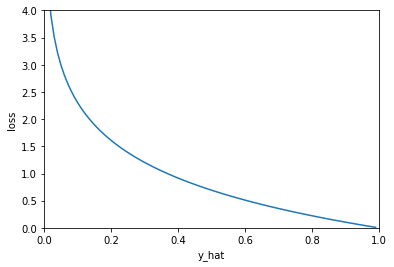

In [6]:
x = np.arange(1e-4,1,0.01)
plt.plot(x, -np.log(x))
plt.axis([0,1,0,4])
plt.xlabel("y_hat")
plt.ylabel("loss")
plt.show()

Now the loss is high when the prediction $\hat{y}$ is far from the correct value of 1.

The loss for one example is the sum of the losses over each class, and the total cost is the average of the losses for each example.

To sum all of these efficiently, we can exploit the fact that the labels are `1`s and `0`s.
We can add all the losses for one example $i$ using the equation 

$$L_i = {\sum_{j \in \textrm{classes}}} -y_j\cdot \log(\hat{y_j}) -(1-y_j)\cdot \log(1-\hat{y}_j)$$

where $y_j$ is the label for class $j$ of example $i$ (with a value of 1 or 0) and $\hat{y}_j$ is the prediction.

Note that if the label for class $j$ is 1, then $-y_j\cdot \log(\hat{y_j}) -(1-y_j)\cdot \log(1-\hat{y}_j)$ is the same as $-y_j\cdot \log(\hat{y_j})$, and if the label is 0, it is $-(1-y_j)\cdot \log(1-\hat{y}_j)$. So everything is added correctly.

The total cost for $m$ examples is $J = \frac{1}{m} {\sum_{i=1}^m} L_i$

Implement the cost function here:

In [7]:
def compute_cost(y_hat, y):
    '''
    Input
    -----
    y_hat: computed class scores
    y: true classes
    
    Output
    ------
    loss: total loss (scalar)
    '''
    num_examples = y.shape[0]
    
    logloss = y * np.log(y_hat) + (1-y) * np.log(1-y_hat)
    cost = - np.sum(logloss) / num_examples
    
    return cost

## Backward propogation


We want to minimize the cost. To do so, we compute the gradient of the loss with respect to each of our weights ($W_1$, $b_1$, $W_2$, $b_2$). The gradient is the direction of greatest increase of the cost, so we subtract the gradient times a learning rate from all the weights to make the cost smaller.

Remember from before,

* Input is $x$
* $W_1 \cdot x + b_1 = z_1$
* $a_1 = \textrm{tanh}(z_1)$
* $W_2 \cdot a_1 + b_2 = z_2$
* $a_2 = \textrm{sigmoid}(z_2)$
* The predicted class scores are $\hat{y} = a_2$

and then we compute the losses $L_i = {\sum_{j \in \textrm{classes}}} -y_j\cdot \log(\hat{y_j}) -(1-y_j)\cdot \log(1-\hat{y}_j)$
and the total cost $J = \frac{1}{m} {\sum_{i=1}^{m}} L_i$.

We need to find the [partial derivatives](https://en.wikipedia.org/wiki/Partial_derivative) of $J$ with respect to each of $W_1$, $b_1$, $W_2$, and $b_2$.
We do this by moving backwards through the process:

Intermediate derivative: $\frac{\partial J}{\partial L_i} \cdot \frac{\partial L_i}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z_2} = \frac{\partial J}{\partial z_2} = \frac{1}{m} {\sum_j} (\hat{y}_j - y_j)$

Find $\frac{\partial J}{\partial W_2}$: $\frac{\partial J}{\partial z_2} \cdot \frac{\partial z_2}{\partial W_2} = \frac{1}{m} {\sum_j} (\hat{y}_j - y_j) \cdot a_1 = \frac{\partial J}{\partial W_2}$

Find $\frac{\partial J}{\partial b_2}$: $\frac{\partial J}{\partial z_2} \cdot \frac{\partial z_2}{\partial b_2} = \frac{1}{m} {\sum_j} (\hat{y}_j - y_j) \cdot 1 = \frac{\partial J}{\partial b_2}$

Intermediate derivative: $\frac{\partial z_2}{\partial a_1} \cdot \frac{\partial a_1}{\partial z_1} = W_2 \cdot (1 - a_1^2)$

Find $\frac{\partial J}{\partial W_1}$: $\frac{\partial J}{\partial z_2} \cdot \frac{\partial z_2}{\partial z_1} \cdot \frac{\partial z_1}{\partial W_1} = \frac{1}{m} {\sum_j} (\hat{y}_j - y_j) \cdot W_2 \cdot (1 - a_1^2) \cdot x $

Find $\frac{\partial J}{\partial b_1}$: $\frac{\partial J}{\partial z_2} \cdot \frac{\partial z_2}{\partial z_1} \cdot \frac{\partial z_1}{\partial b_1} = \frac{1}{m} {\sum_j} (\hat{y}_j - y_j) \cdot W_2 \cdot (1 - a_1^2) \cdot 1$

Make sure to account for dimensions when you implement it in code.

Implement backpropogation here:

In [8]:
def backprop(parameters, cache, X, y):
    '''
    Input
    -----
    parameters: dictionary of weights
    cache: intermediate variables from most recent computation
    X: array of input examples
    y: true classes
    
    Output
    ------
    grads: dictionary of gradients
    '''
    num_examples = X.shape[1]
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = cache["Z1"]
    A1 = cache["A1"]
    Z2 = cache["Z2"]
    y_hat = cache["y_hat"]
    
    dZ2 = y_hat - y
    dW2 = (1 / num_examples) * np.dot(dZ2, A1.T)
    db2 = (1 / num_examples) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / num_examples) * np.dot(dZ1, X.T)
    db1 = (1 / num_examples) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

## Update the weights

Subtract the gradients times the learning rate from the weights.

In [9]:
def update_params(parameters, grads, learning_rate=0.001):
    '''
    Input
    -----
    parameters: dictionary of weights
    grads: dicitonary of gradients
    learning_rate: learning rate
    
    Output
    ------
    parameters: dictionary of updated weights
    ''' 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}

    return parameters

## Model

Putting it all together

In [20]:
def nn_model(X, y, n_h, num_iterations=50000):
    '''
    Input
    -----
    X: array of input examples
    y: true classes
    n_h: number of hidden nodes
    num_iterations: number of times to update the weights
    
    Output
    ------
    parameters: the weights of the trained model
    '''
    n_x = X.shape[0]
    n_y = y.shape[0]
    
    costs = []
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(num_iterations):
        y_hat, cache = forward_propogation(X, parameters)
        cost = compute_cost(y_hat, y)
        costs.append(cost)
        grads = backprop(parameters, cache, X, y)
        parameters = update_params(parameters, grads)
        
    return parameters, costs

### Train-test split

Set aside some of the data to evaluate the model later. We want to evaluate the model with data it's never seen before.

In [15]:
train = np.random.choice(range(X.shape[1]), int(0.7*X.shape[1]))
test = [i for i in range(X.shape[1]) if i not in train]

X_train = X[:,train]
X_test = X[:,test]
y_train = y[:,train]
y_test = y[:,test]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4, 105)
Shape of y_train: (3, 105)
Shape of X_test: (4, 76)
Shape of y_test: (3, 76)


### Train

In [22]:
# we'll have 4 nodes in the hidden layer
n_h = 4

params, costs = nn_model(X_train, y_train, n_h)

### Test

In [23]:
y_hat, _ = forward_propogation(X_test, params)

predicted = y_hat.argmax(0)
y_test_classes = y_test.argmax(0)

acc = np.sum(y_test == predicted) / float(y_test.shape[1])

print("Percent correct: %f%%" % (acc*100))

Percent correct: 94.736842%


## Evaluate

Loss and such

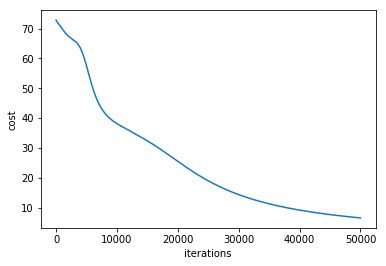

In [24]:
x=np.arange(0,50000,1)
plt.plot(x, costs)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.show()

## Further improvements / study

Some other things you could look into:
* How does changing the number of nodes in the hidden layer affect training and accuracy?
* Overfittting?
* Regularization?
* Cross-validation?

Also note that you can rearrange the linear algebra equations a bit and still arrive ate the same answer.